# Pacotes

In [1]:
%config InlineBackend.figure_format = 'retina'

# Pacotes gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes estatísticos
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1]
    conclusion = result < signif
    for j in range(k):
      print(f'p-value = {result[j]}')
      print("Reject H0 on lag " ,j+1,"? ", conclusion[j], "\n")
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM statistic: ', result[0])
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F statistic: ', result[2])
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('paper')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [3]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    sns.set_context('paper')
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} defasada em {trimestres[i]} trimestres')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} defasada em {trimestres[i]} trimestres')
    
    return fig

# Dados

In [5]:
df = pd.read_csv(
    '../data/raw_data.csv',
    index_col=[0], 
    parse_dates=True
)
df = df[[
    "ICMS Nominal milhões de reais", 
    "Índice da Produção Física Industrial com ajuste sazonal (Média 2012 = 100)",
    "Taxa de câmbio",
    "Exportações FOB",
    "Importações FOB"
]]
df.columns = ["ICMS", "Industrial", "Cambio", "Exportacoes", "Importacoes"]
df = df[["Exportacoes", "Cambio", "Importacoes", "Industrial", "ICMS"]] ## Ordenação de Cholesky
df = df.apply(pd.to_numeric, errors='coerce')
df

,Exportacoes,Cambio,Importacoes,Industrial,ICMS
2002-01-31,1262216472,2.3771,1588583185,75.7,2956.253605
2002-02-28,1345978624,2.4188,1507819585,78.6,2612.977840
2002-03-31,1443341004,2.3458,1654236906,78.1,2603.100729
2002-04-30,1614508483,2.3196,1752896831,78.2,2964.822876
2002-05-31,1491268802,2.4796,1666945463,78.0,2848.263981
...,...,...,...,...,...
2019-11-30,4151531373,4.1547,4686437048,84.4,12733.549560
2019-12-31,4110201326,4.1089,4131330689,83.5,14602.358693
2020-01-31,3038691669,4.1489,5063918443,84.6,13082.640610
2020-02-29,3363940383,4.3404,3966864513,83.5,11927.616739


# Modelo

## Ordem do modelo

In [36]:
model = VAR(
    #df.diff().dropna(),
    df.pct_change().dropna(),
    #df.pct_change(12).dropna(),
    freq="M", 
)
model.select_order(maxlags=15, trend='c').summary()

,AIC,BIC,FPE,HQIC
0,-27.27,-27.19,1.434e-12,-27.24
1,-28.31,-27.82*,5.069e-13,-28.11
2,-28.57,-27.68,3.897e-13,-28.21
3,-28.75,-27.44,3.286e-13,-28.22*
4,-28.75*,-27.04,3.262e-13*,-28.06
5,-28.68,-26.56,3.511e-13,-27.83
6,-28.58,-26.05,3.938e-13,-27.55
7,-28.44,-25.51,4.523e-13,-27.25
8,-28.40,-25.06,4.756e-13,-27.05
9,-28.37,-24.62,4.973e-13,-26.85


## Estimação

In [37]:
results = model.fit(
    maxlags=4, 
)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, May, 2020
Time:                     17:02:24
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -26.8780
Nobs:                     214.000    HQIC:                  -27.8622
Log likelihood:           1639.40    FPE:                4.08456e-13
AIC:                     -28.5296    Det(Omega_mle):     2.55785e-13
--------------------------------------------------------------------
Results for equation Exportacoes
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.040636         0.009695            4.191           0.000
L1.Exportacoes        -0.542489         0.077663           -6.985           0.000
L1.Cambio             -0.048075         0.240008  

### Pós estimação

#### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

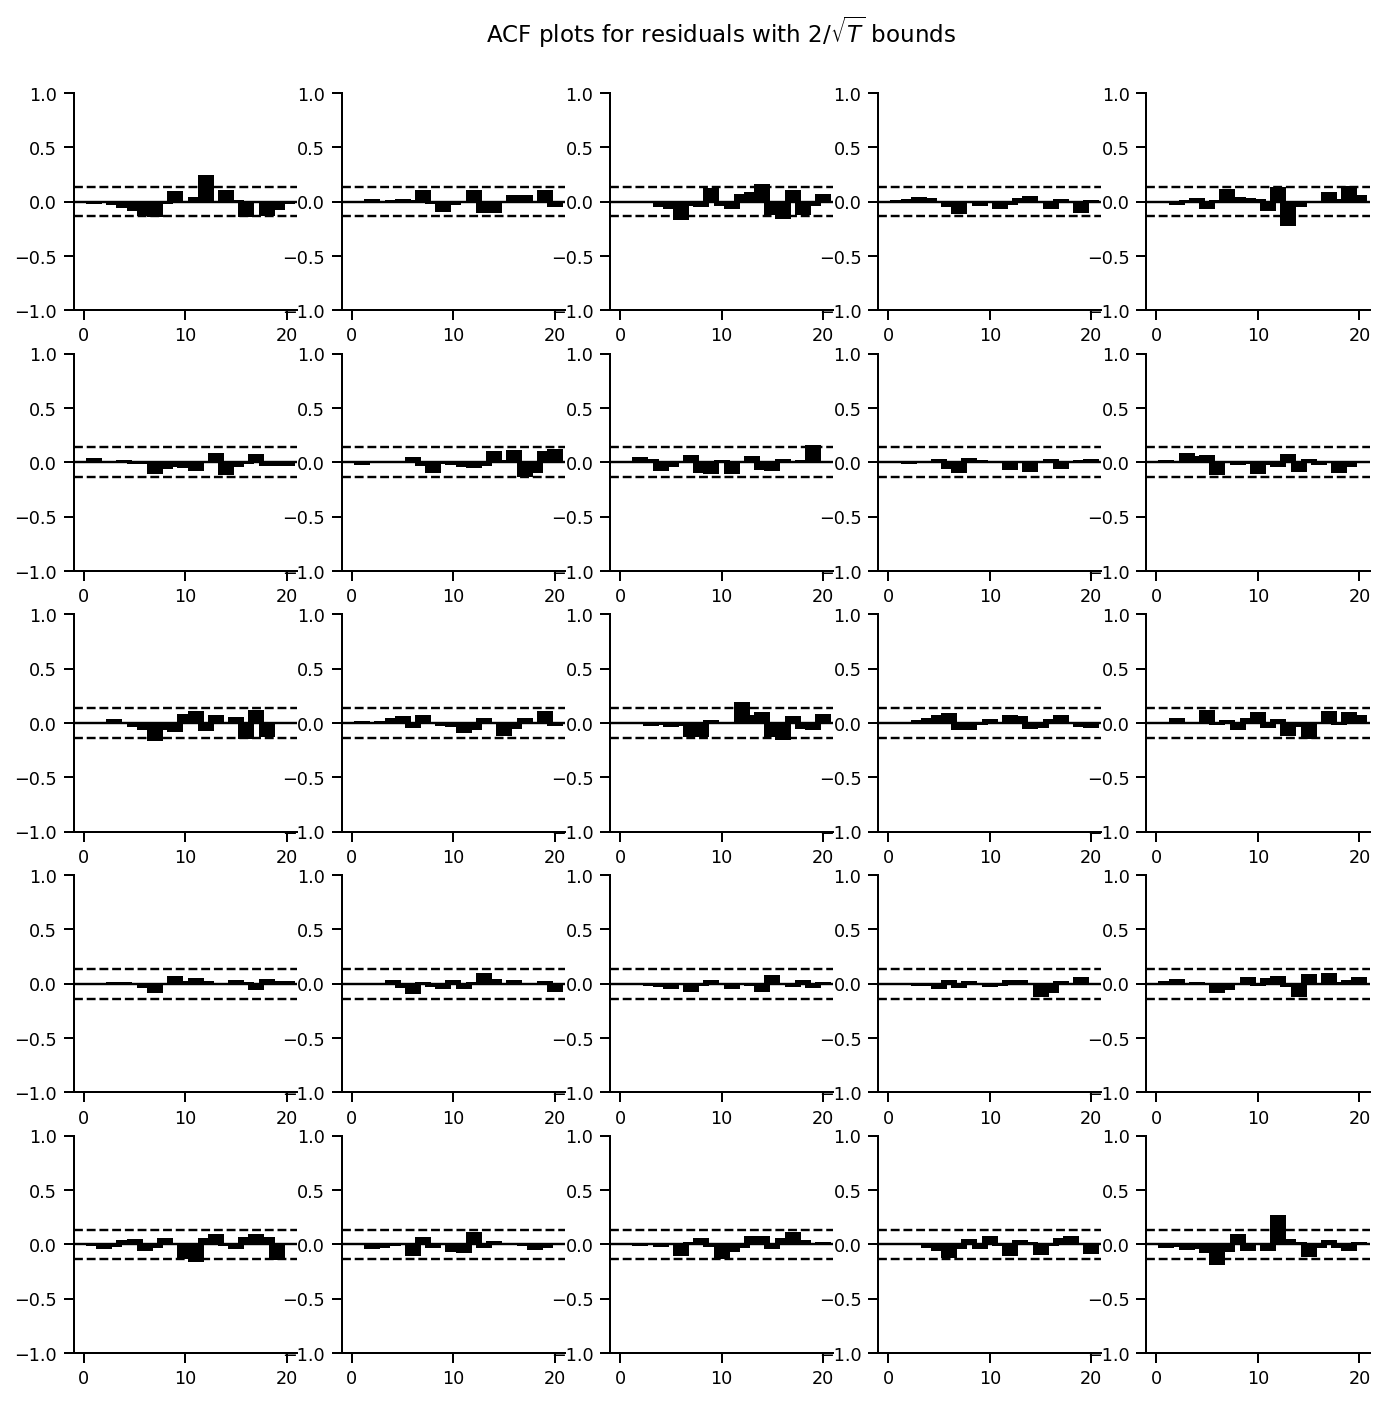

In [38]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

### Estabilidade

In [39]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.6146801227594278
0.6146801227594278
0.6055815071643497
0.6055815071643497
0.7442787741632403
0.7442787741632403
0.6342305637606218
0.6342305637606218
0.6649980105242891
0.6649980105242891
0.7983906032505461
0.7983906032505461
0.7564312031136785
0.7564312031136785
0.1663724760957284
0.5875629815351318
0.5875629815351318
0.6601187182058059
0.6601187182058059
0.6232730894511768
Estável: True


### Inspeção dos resíduos

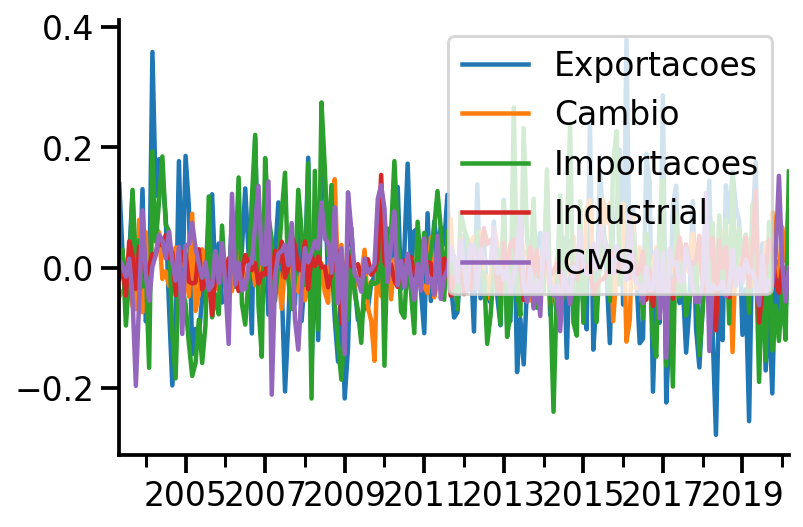

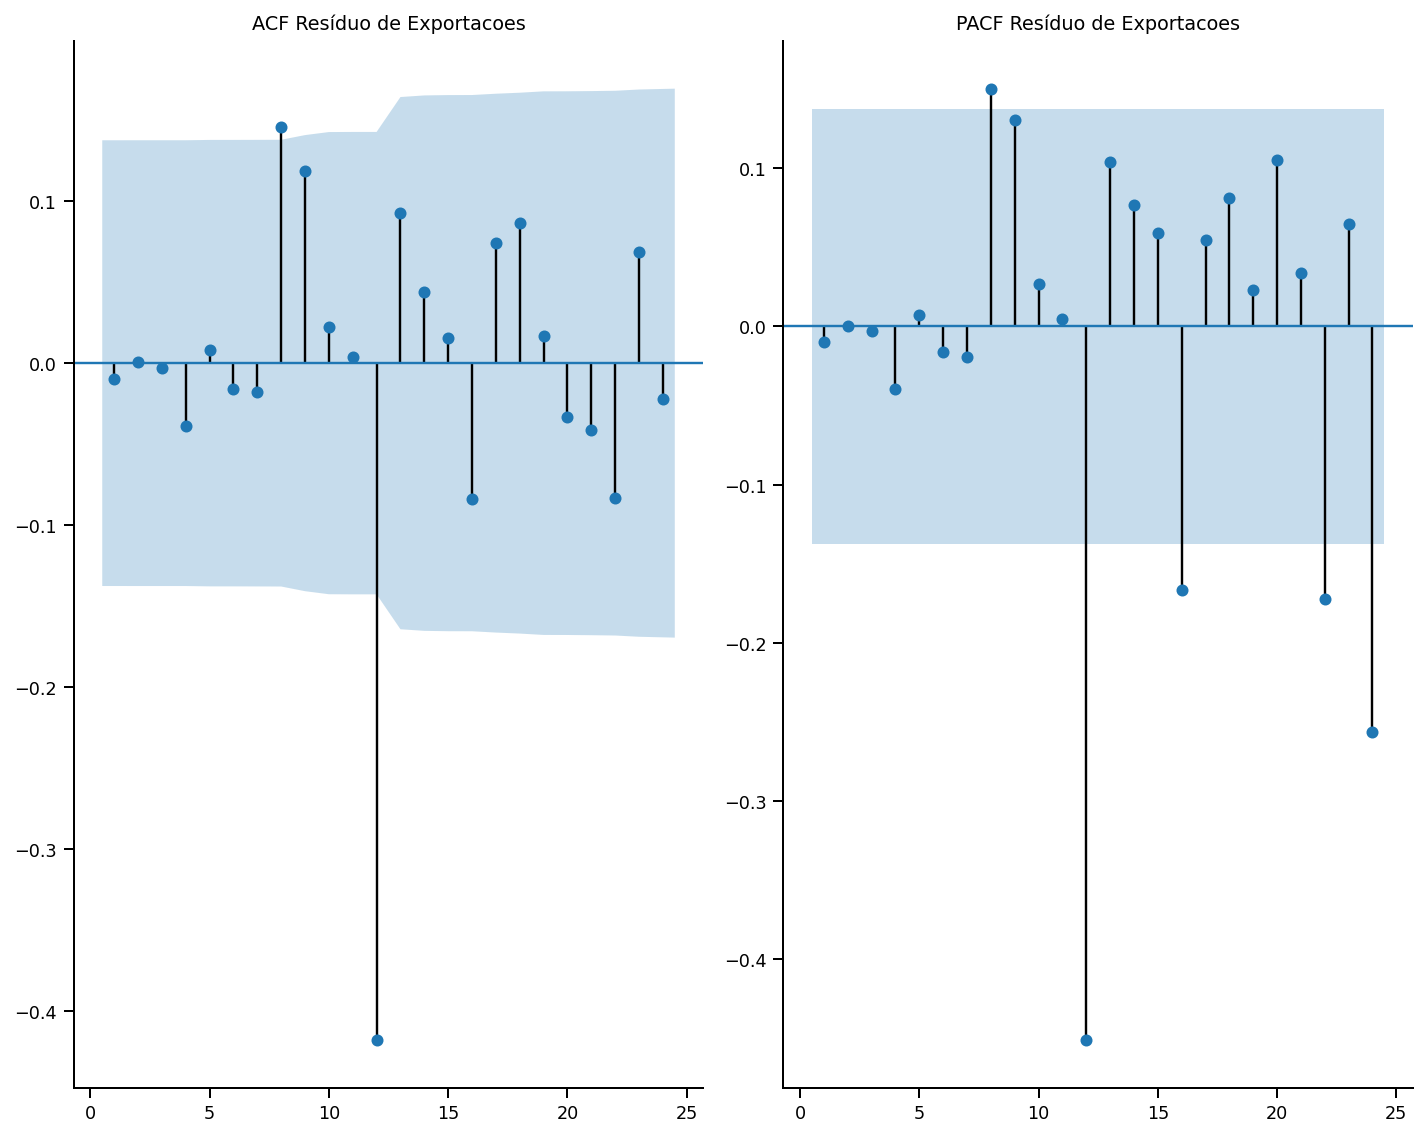

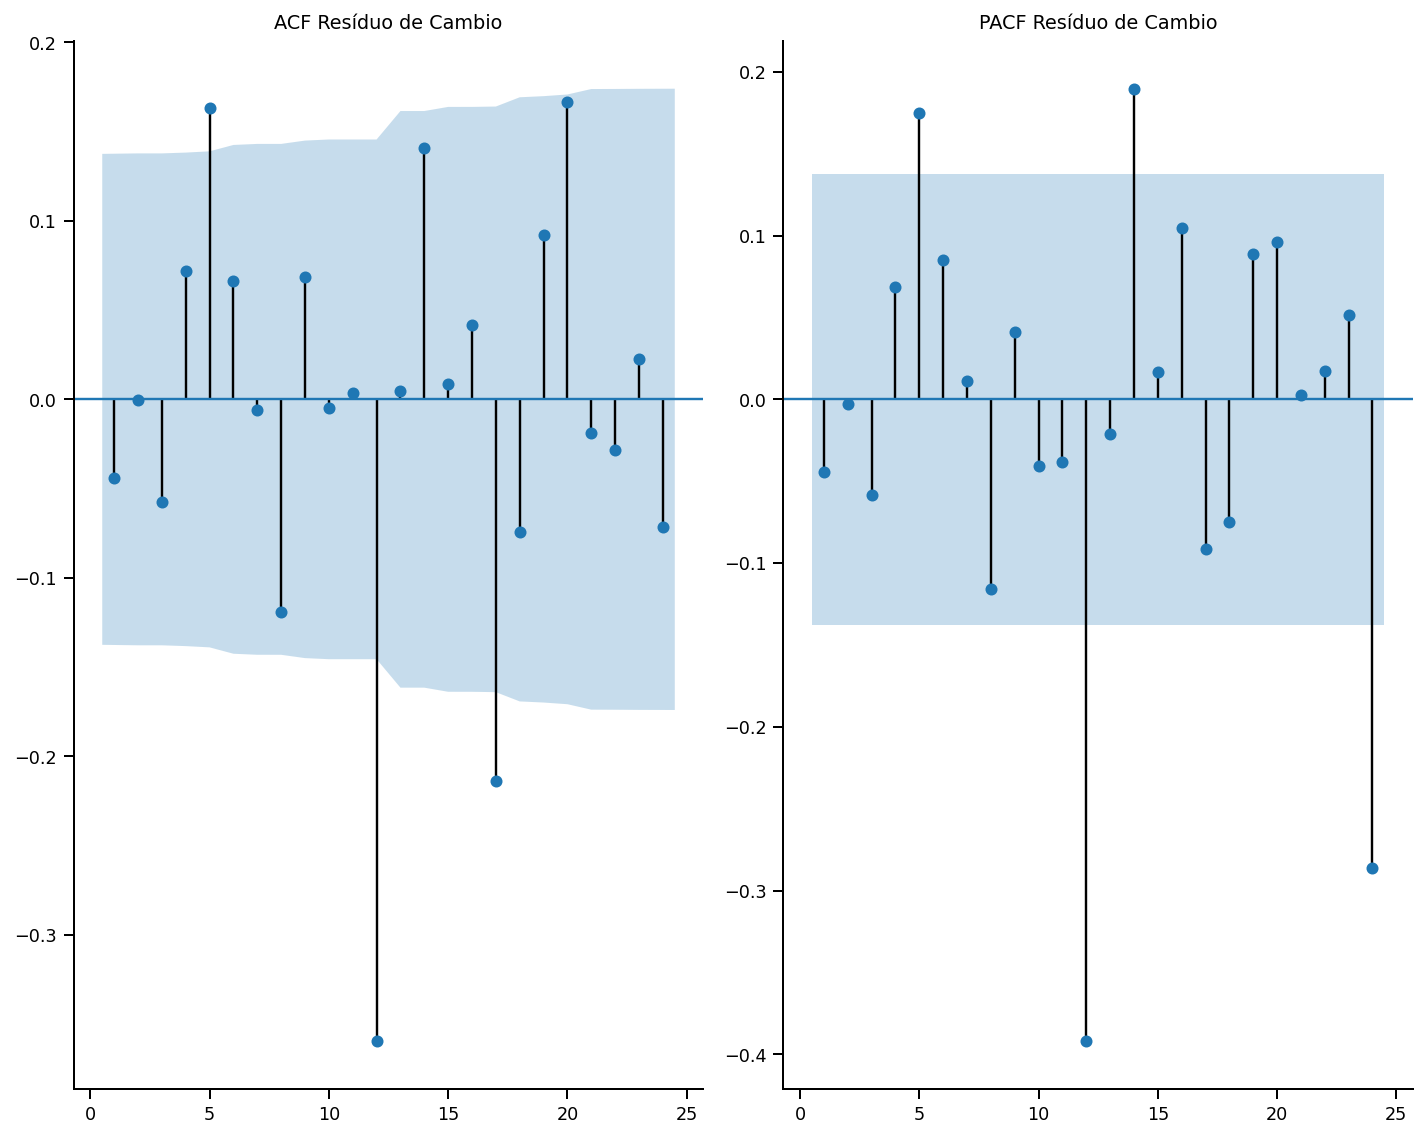

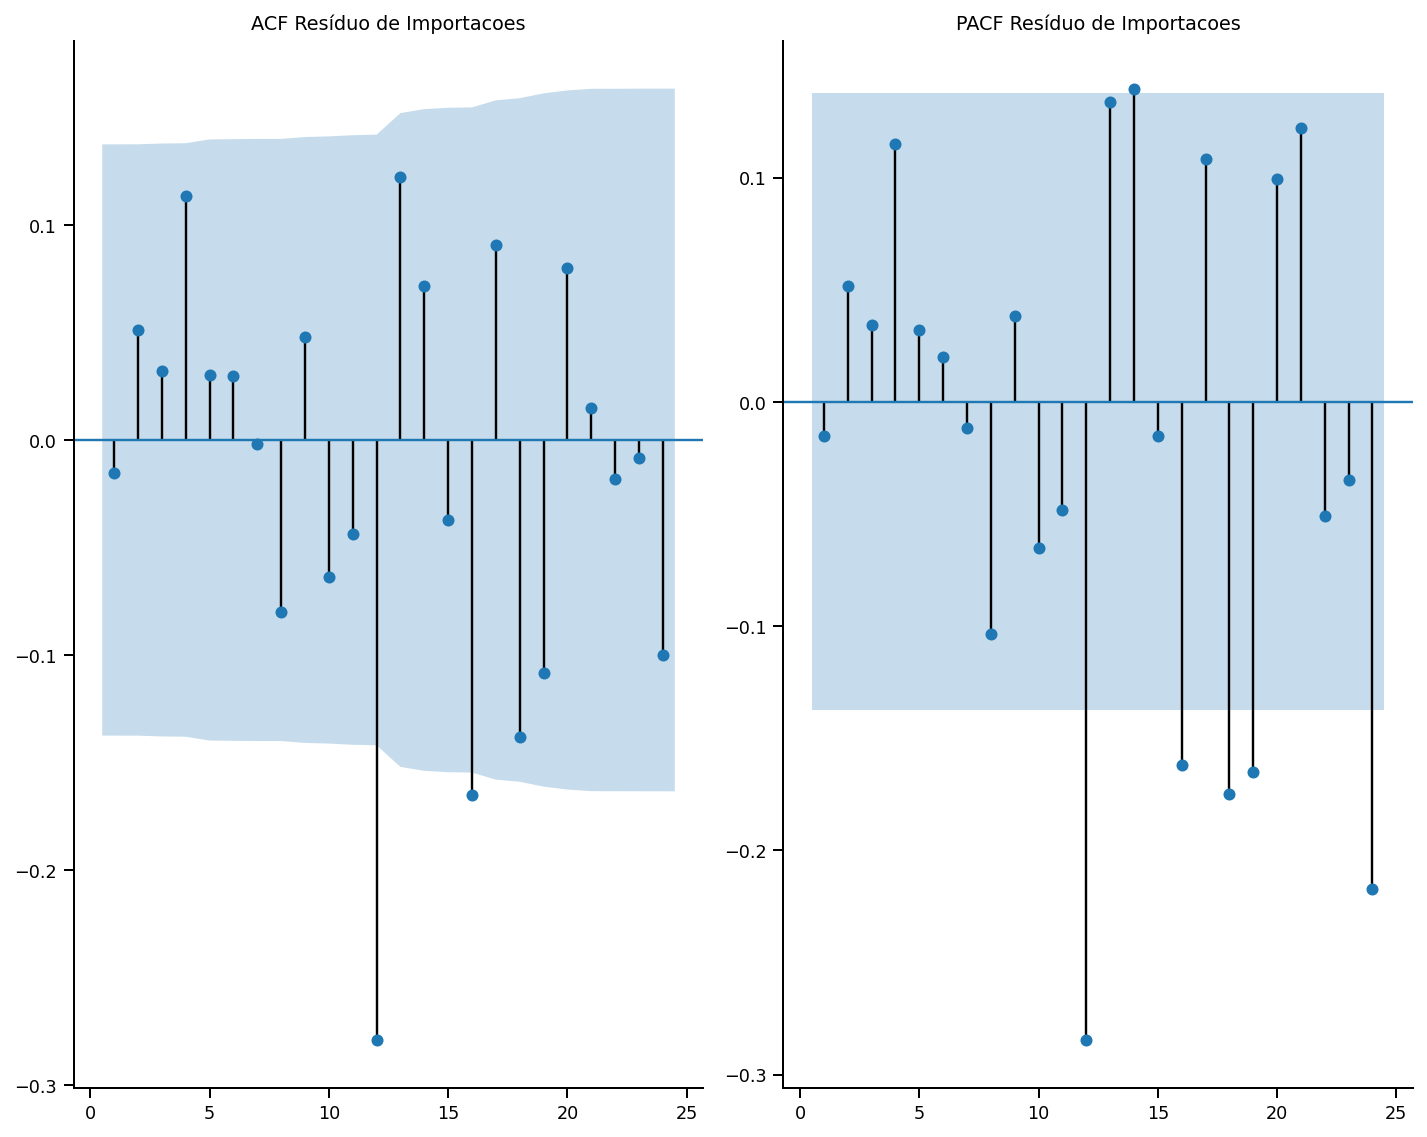

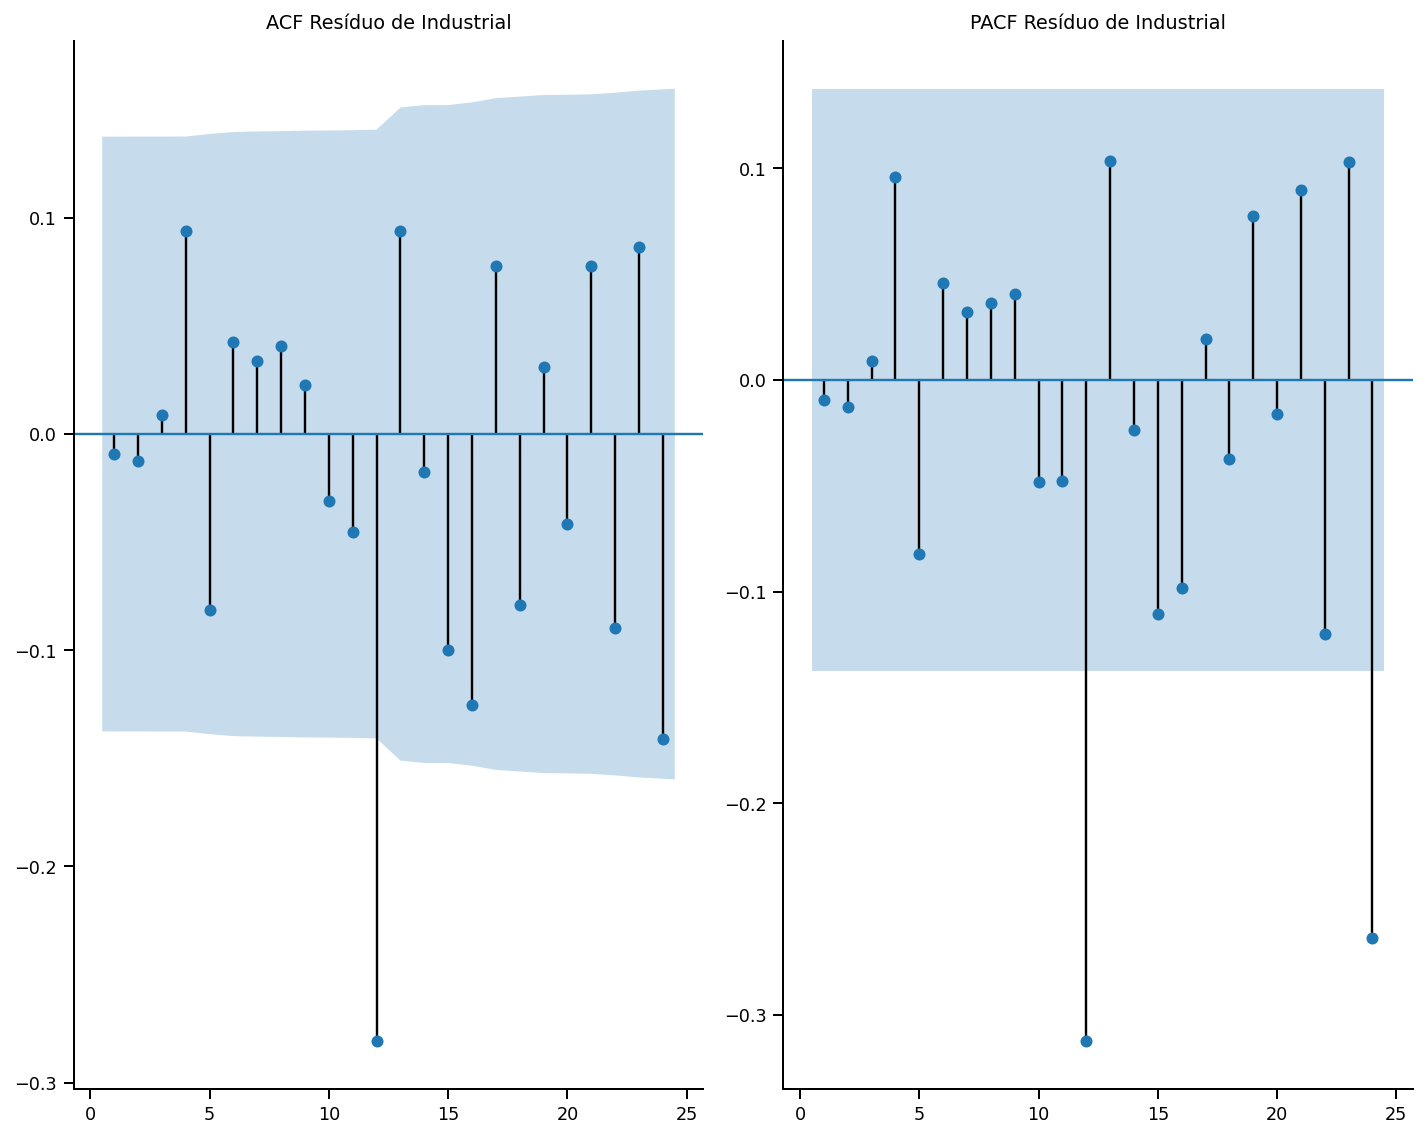

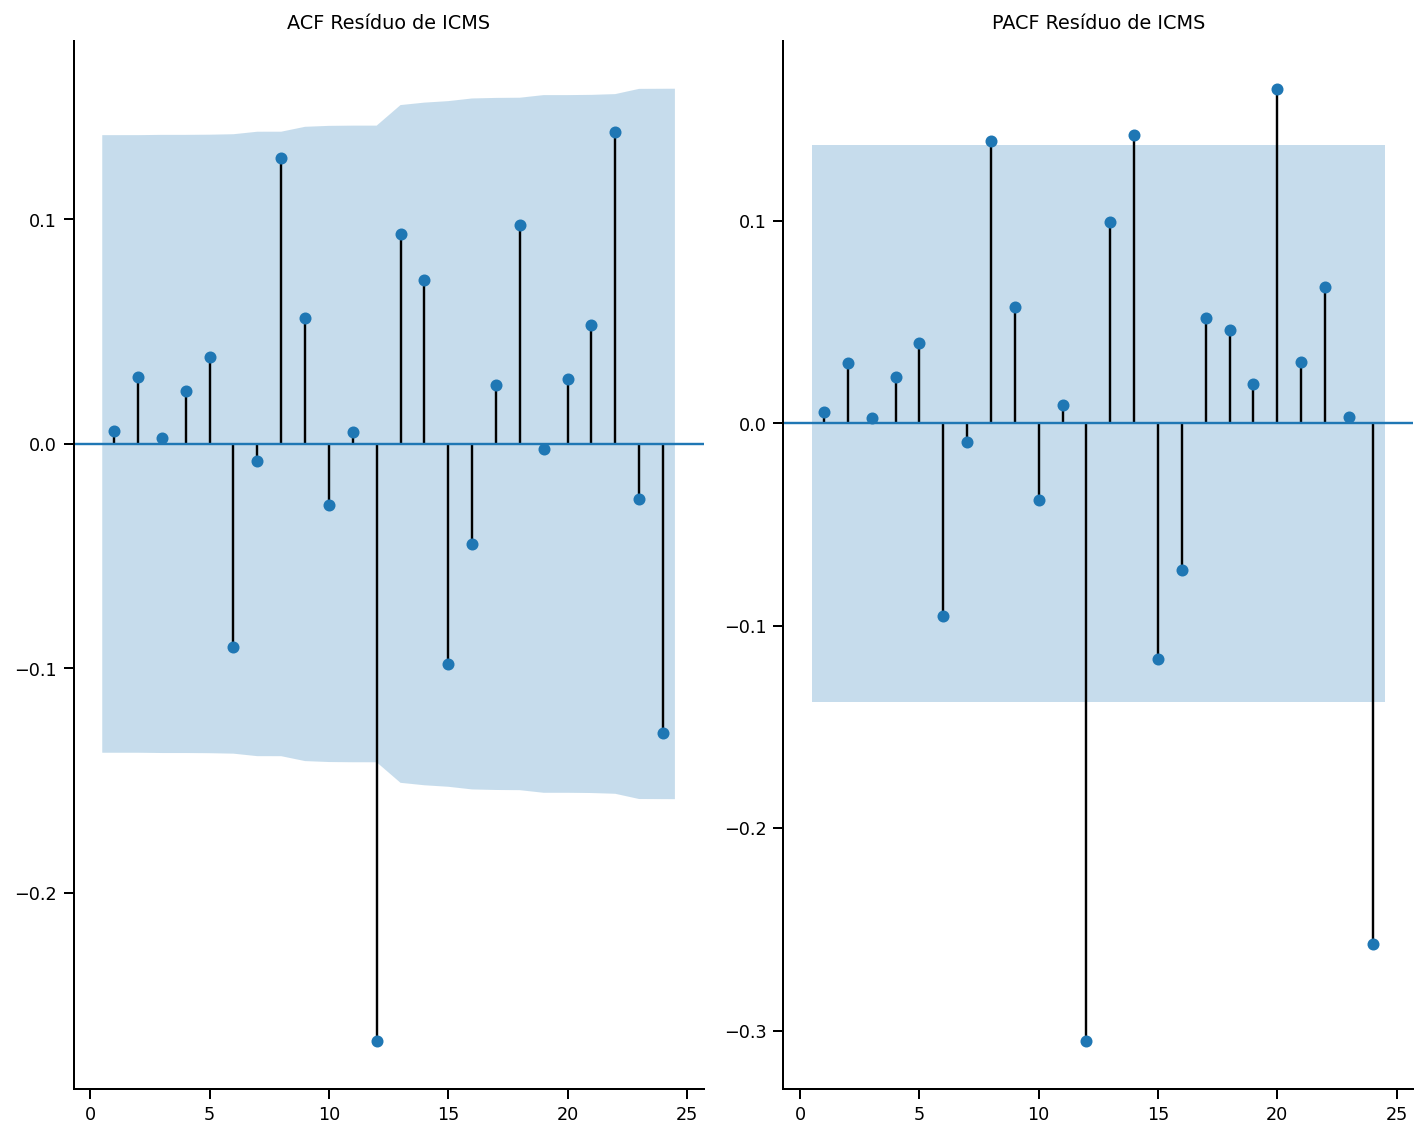

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         407.9          314.7   0.000 275
-----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         429.8          314.7   0.000 275
-----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  EXPORTACOES . Considering a significance level of 5.0 %
p-value = 0.9355289660358296
Reject H0 on lag  1 ?  False 

p-value = 0.9098191440372378

/home/gpetrini/.local/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


IndexError: tuple index out of range

In [31]:
#residuals = analise_residuos(results=results)

In [15]:
# series = results.names
# sns.set_context('talk')
# ax = sns.jointplot(
#     x = series[0], 
#     y = series[1], 
#     data = residuals, color = 'darkred', kind="reg", 
# )
# plt.show()

NameError: name 'residuals' is not defined

## IRF

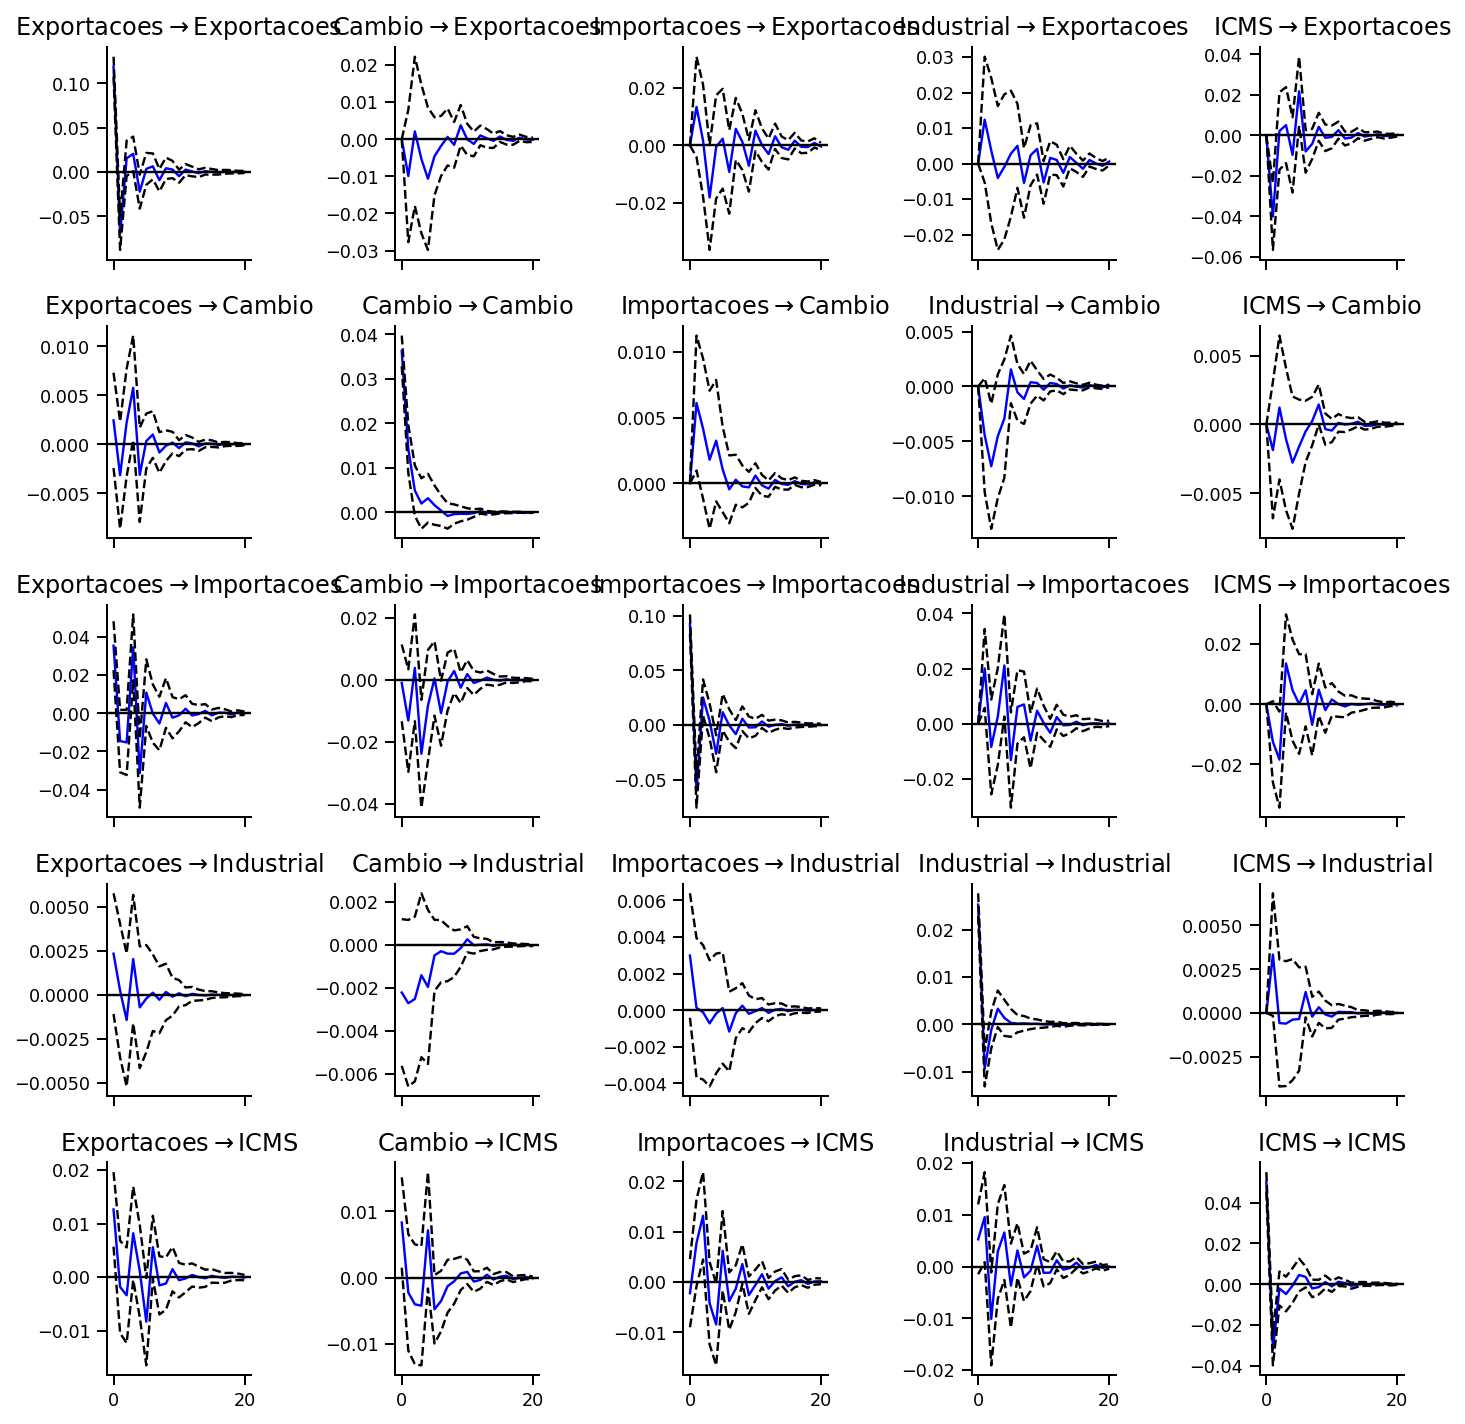

In [40]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
plt.tight_layout()
sns.despine()
plt.show()

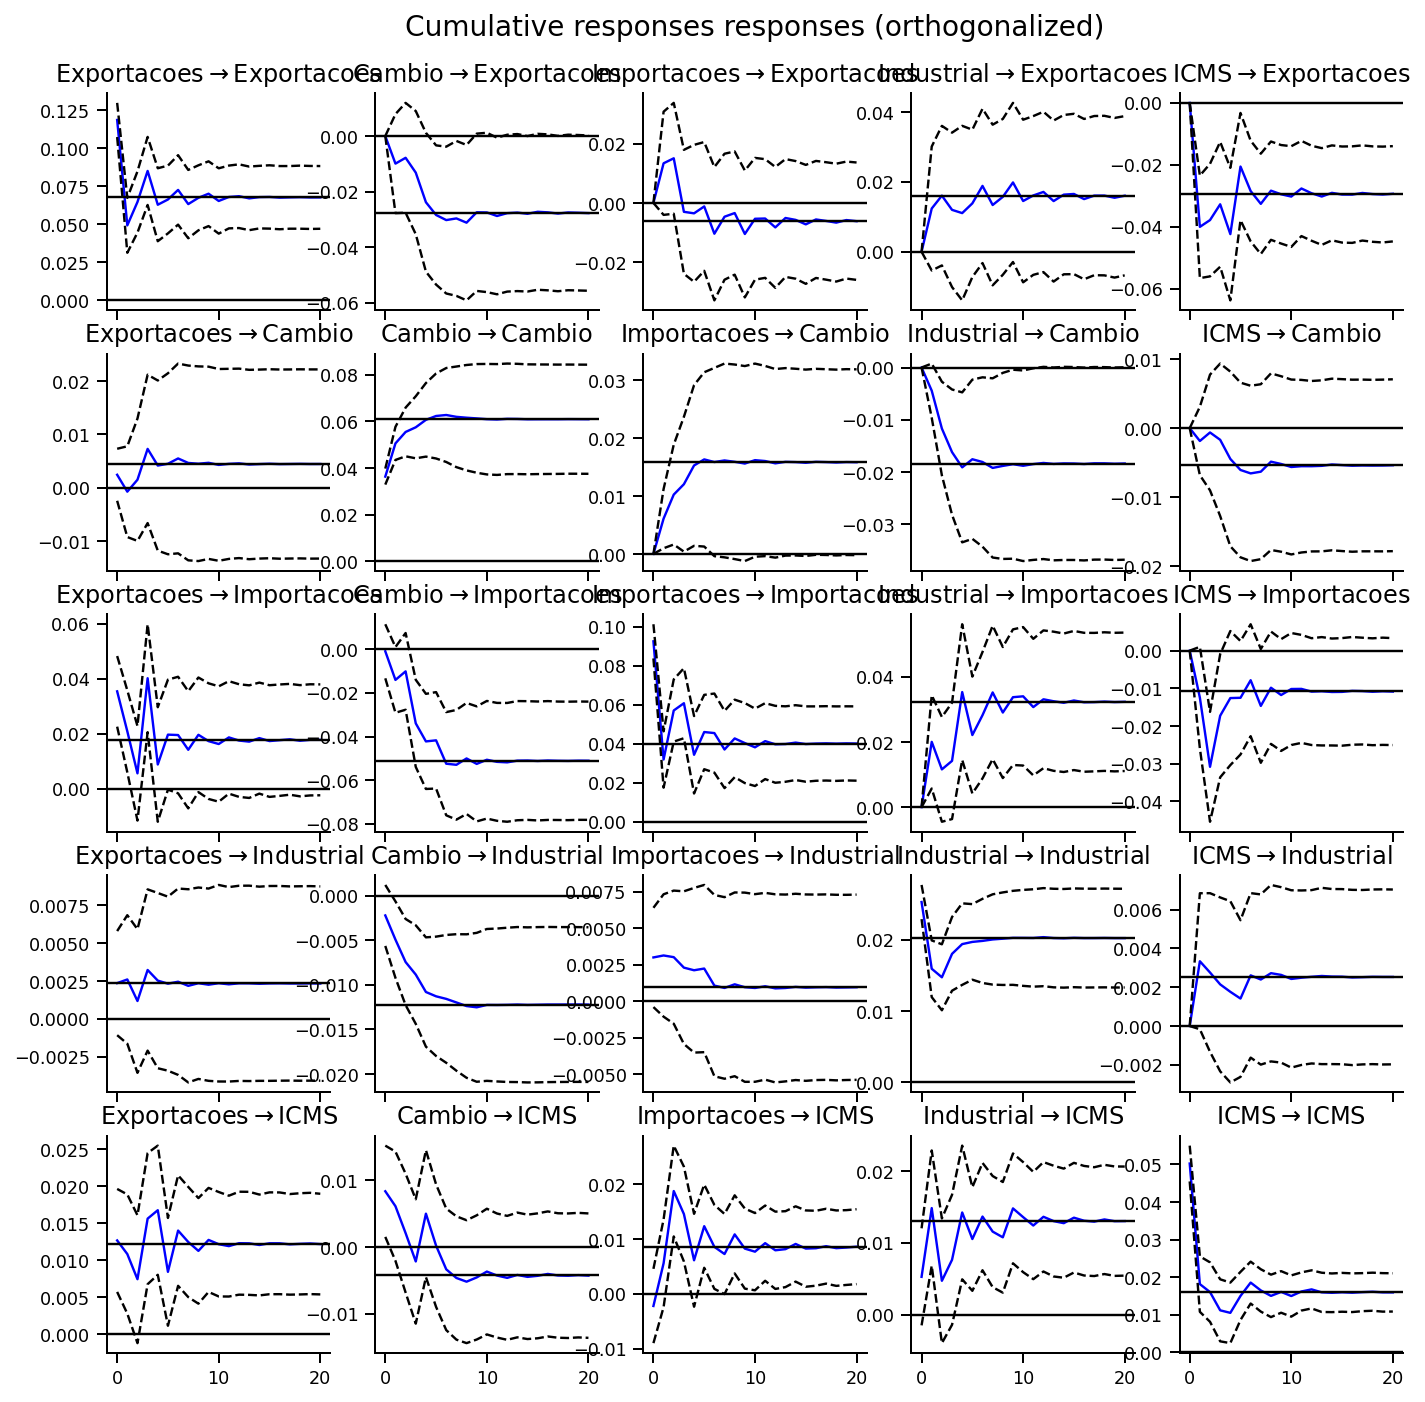

In [41]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()

## Decomposição da variância

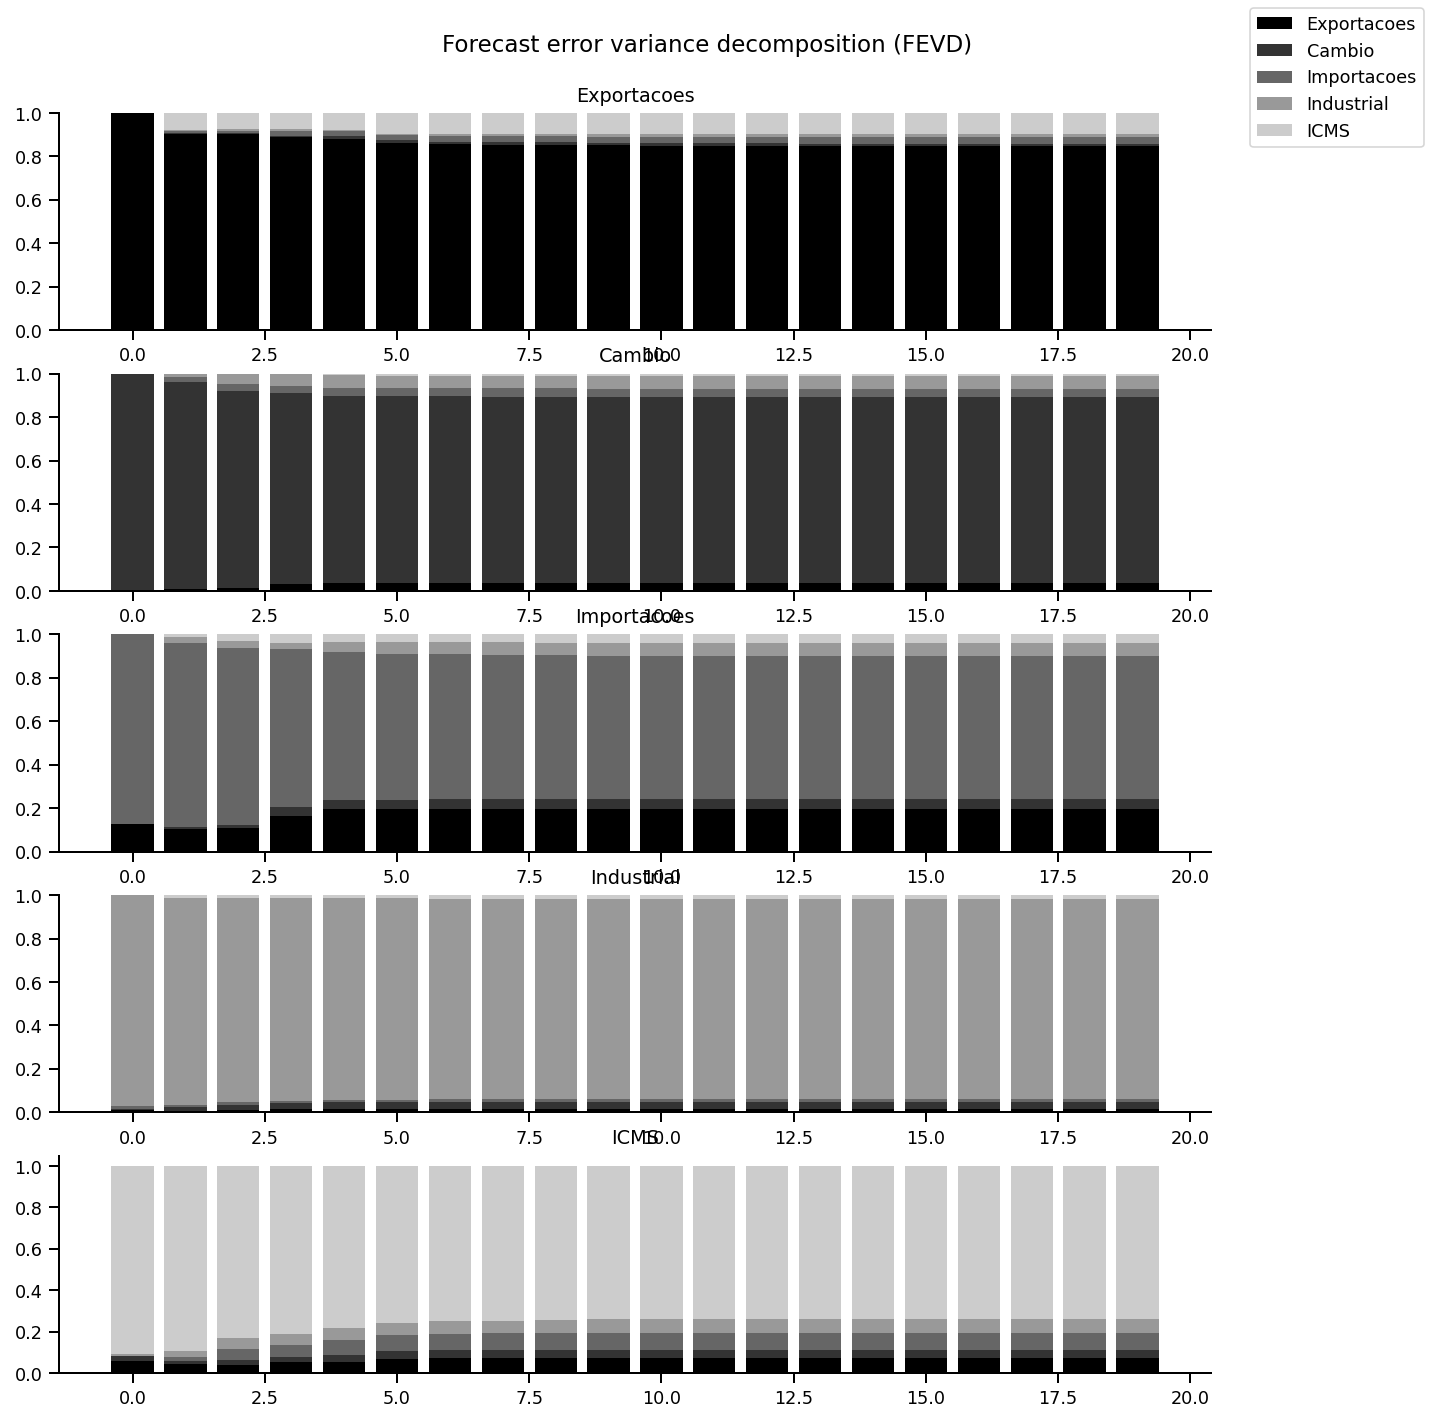

In [42]:
p = results.fevd(20).plot()
sns.despine()
plt.show()

## Previsão

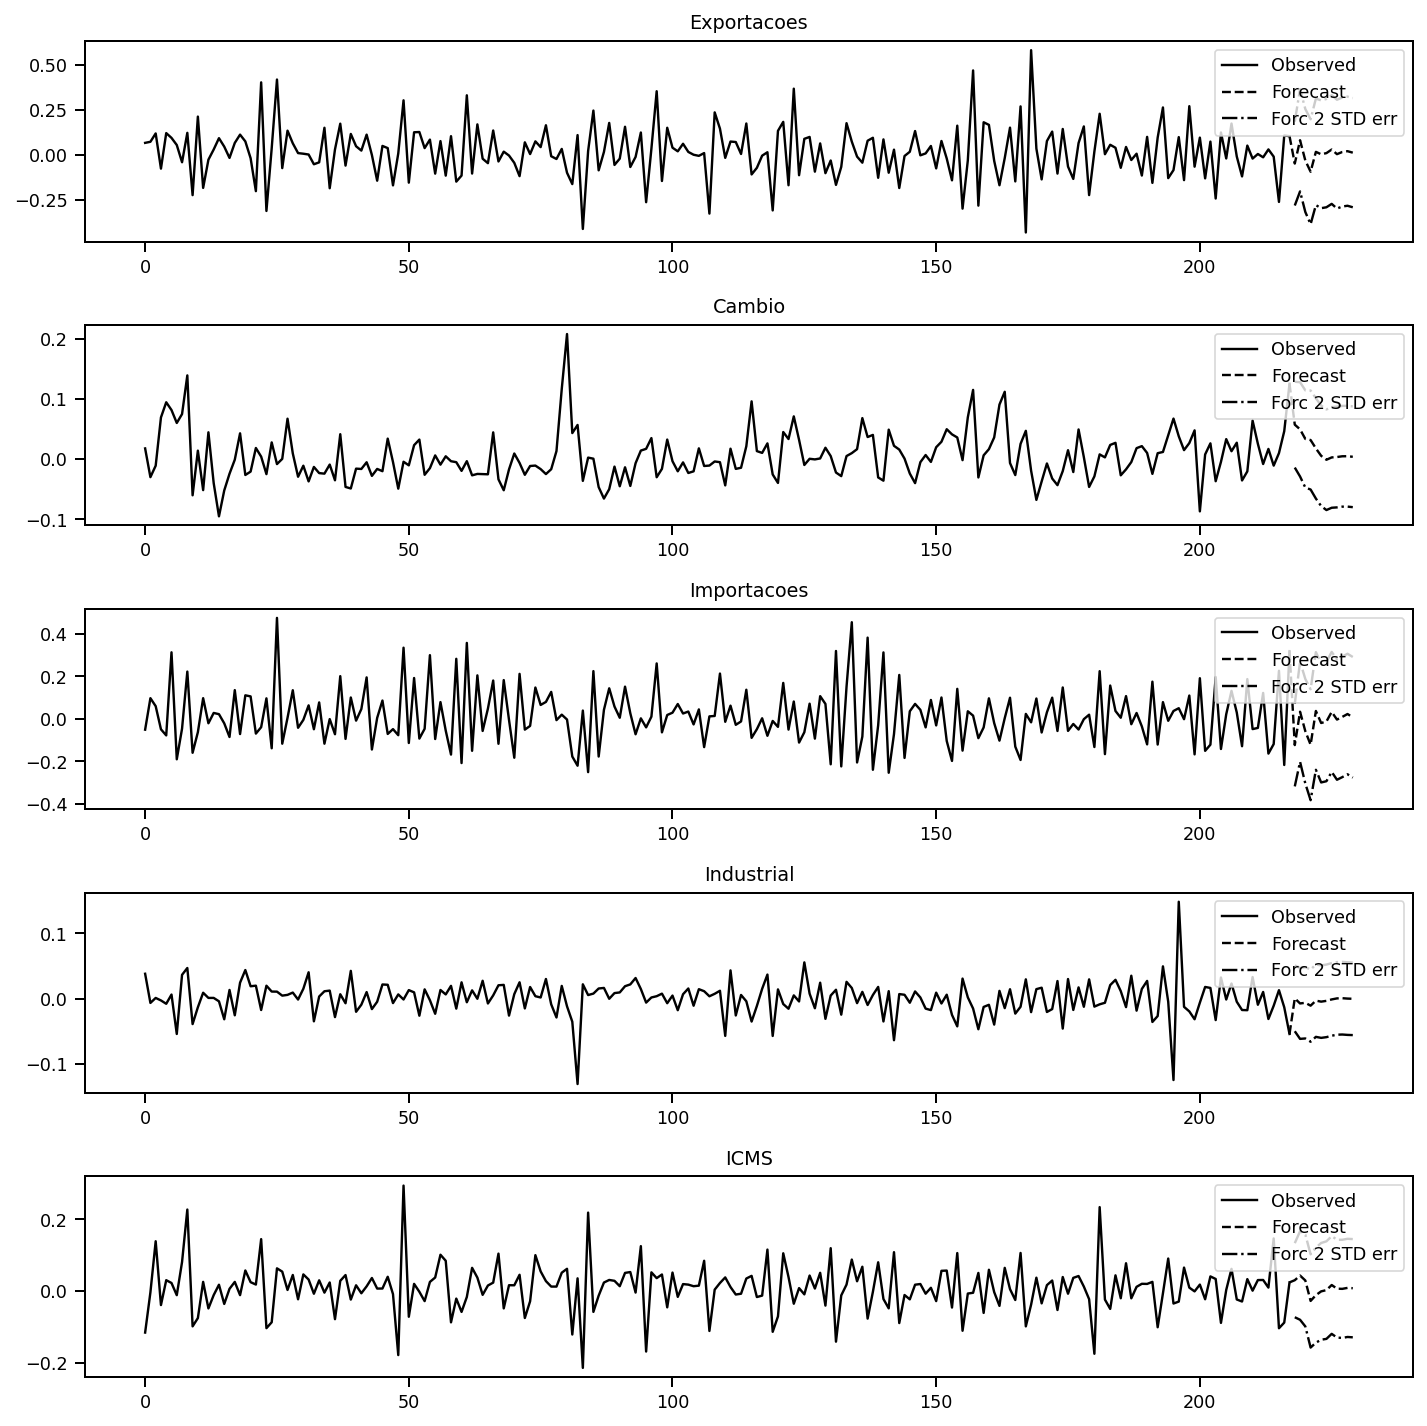

In [43]:
results.plot_forecast(12)
plt.tight_layout()
plt.show()